### Question 3

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#### Part a)

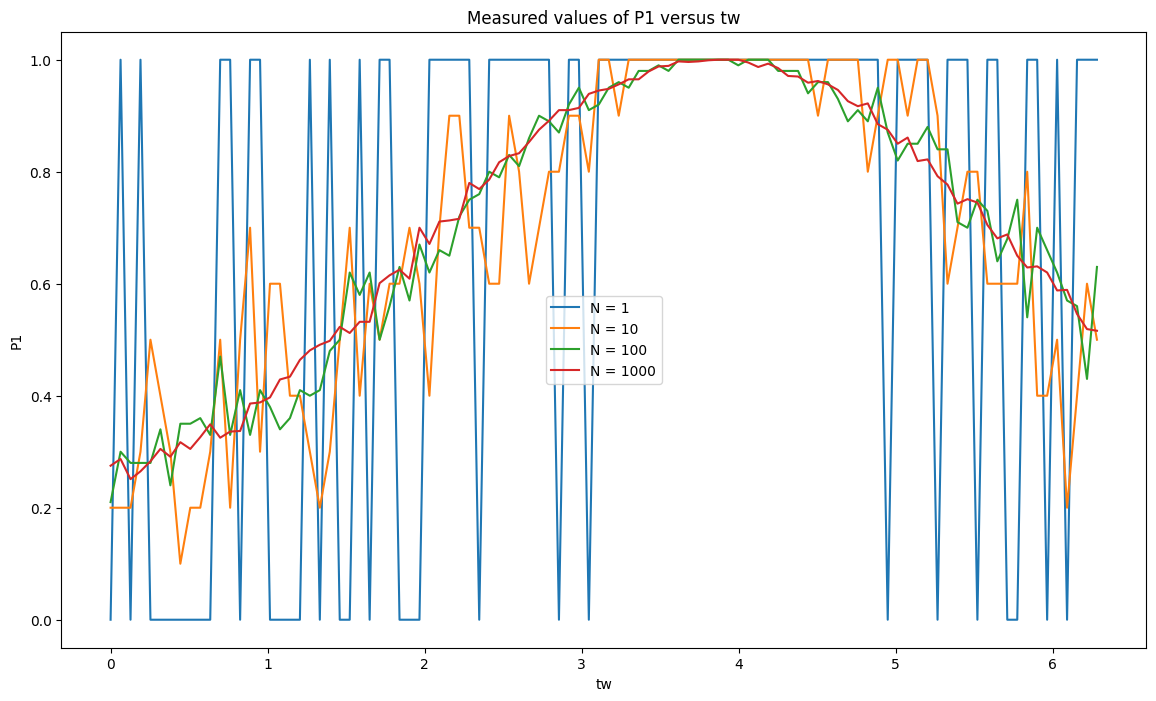

In [54]:
Omega = 2 * np.pi 
delta = np.pi / 4 
Omega_prime = np.sqrt(Omega**2 + delta**2)
tp = np.pi 

# P1 for the qubit in state |1>
def probability_p1(tp, tw, Omega, delta, Omega_prime):
    return 1 - (Omega**2 / Omega_prime**4) * (
        (Omega_prime * np.cos(delta * tw / 2) * np.sin(Omega_prime * tp)) - 
        2 * delta * np.sin(delta * tw / 2) * np.sin(Omega * tp / 2)**2
    )**2

# function to simulate the binomial distribution for P1
def simulate_p1(tp, tw, Omega, delta, Omega_prime, N):
    p1 = probability_p1(tp, tw, Omega, delta, Omega_prime)
    # Generate data from a binomial distribution
    data = np.random.binomial(n=N, p=p1) / N  # N trials
    return data

N_values = [1, 10, 100, 1000]

tw_values = np.linspace(0, 2 * np.pi, 100)  # tw will vary from 0 to 2*pi

# initialize a dictionary to hold the simulated data for each N
simulated_data = {N: [] for N in N_values}

# generate the simulated data for each N and tw value
for N in N_values:
    for tw in tw_values:
        simulated_data[N].append(simulate_p1(tp, tw, Omega, delta, Omega_prime, N))

plt.figure(figsize=(14, 8))

for N in N_values:
    plt.plot(tw_values, simulated_data[N], label=f'N = {N}')

plt.title('Measured values of P1 versus tw')
plt.xlabel('tw')
plt.ylabel('P1')
plt.legend()
plt.show()


#### Part b)

In order to find where P1 = 1/2 we plot a curve fit for the data using our P1 equation

In [55]:
def fitting_function(tw, Omega_fit, delta_fit, scale_Omega_prime):
    Omega_prime_fit = np.sqrt(Omega_fit**2 + delta_fit**2) * scale_Omega_prime
    return probability_p1(tp, tw, Omega_fit, delta_fit, Omega_prime_fit)

fit_params = {}
tw_at_p1_half_curve = {}

# Skip N=1 for plotting as it does not have a slope around tw=2
N_values = [1, 10, 100, 1000] 

# lets ignore N = 1 since it does not give us expected P1 = 1/2
for N in N_values:
    tw_data = tw_values
    p1_data = simulated_data[N]

    initial_params = [Omega, delta, 1]

    params, _ = curve_fit(fitting_function, tw_data, p1_data, p0=initial_params)

    fit_params[N] = params

    target_function = lambda tw: fitting_function(tw, *params) - 0.5
    from scipy.optimize import fsolve

    tw_initial_guess = 2
    tw_solution = fsolve(target_function, tw_initial_guess)
    # Store the solution
    tw_at_p1_half_curve[N] = tw_solution[0]

tw_at_p1_half_curve


{1: 1.5377330096495352,
 10: 1.5114858739002557,
 100: 1.445000432996368,
 1000: 1.3931137082420832}

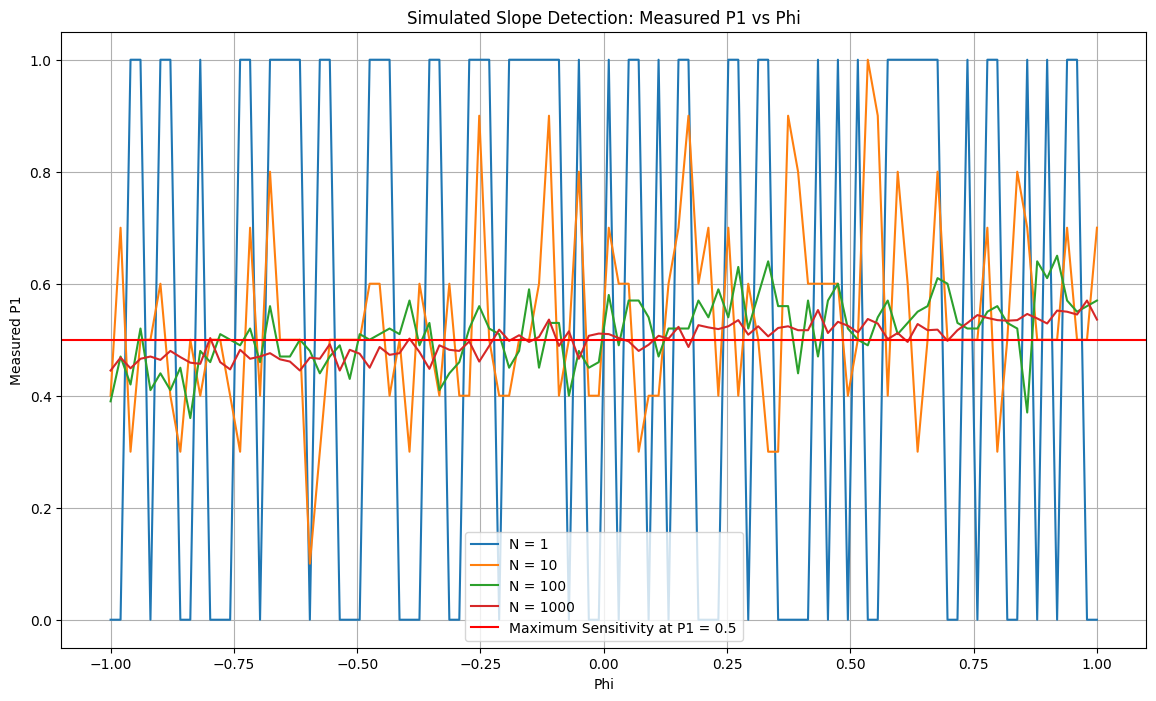

In [56]:
# generate data around these center points
simulated_slope_data = {}
phi_range = np.linspace(-1, 1, 100)  # phi will vary from -1 to 1

for N in N_values:

    simulated_slope_data[N] = []

    # calculate tw for the current phi range using the center tw value
    tw_values_for_N = tw_at_p1_half_curve[N] + phi_range / Omega
    
    for tw in tw_values_for_N:
        p1 = probability_p1(tp, tw, Omega, delta, Omega_prime)
        simulated_slope_data[N].append(simulate_p1(tp, tw, Omega, delta, Omega_prime, N))

# plot P1 vs phi for the N values
plt.figure(figsize=(14, 8))
for N in N_values:
    plt.plot(phi_range, simulated_slope_data[N], label=f'N = {N}')

plt.title('Simulated Slope Detection: Measured P1 vs Phi')
plt.xlabel('Phi')
plt.axhline(y=0.5, color='r', linestyle='-', label='Maximum Sensitivity at P1 = 0.5')
plt.ylabel('Measured P1')
plt.legend()
plt.grid(True)
plt.show()

The Ramsey interferometer is most sensitive to small perturbations $\delta V$ around $V_0 = \frac{\omega_0}{\gamma}$ when operated at the point of maximum slope where $p_0 = 0.5$, indicated by the filled red dot in Fig. 3(a). This bias point is reached when $\omega_0 t = \frac{k\pi}{2}$, with $k = 1, 3, 5, \ldots$ Around $p_0 = 0.5$, the transition probability is linear in $\delta V$ and $t$,

$$
\delta p = \frac{1}{2} \left[1 - \cos(\omega_0 t + \gamma \delta V t)\right] - \frac{1}{2}
$$

$$
\approx \pm \frac{1}{2} \gamma \delta V t,
$$

where the sign is determined by $k$.


This plot shows a linear region around p0=0.5, which confirms the interferometer’s linear response to perturbations in that range, which is what makes it a sensitive measurement tool at that bias point. When the transition probability p0 is 0.5 (the point of maximum slope on the curve), the interferometer is most sensitive to small perturbations δ. 

#### Part c)

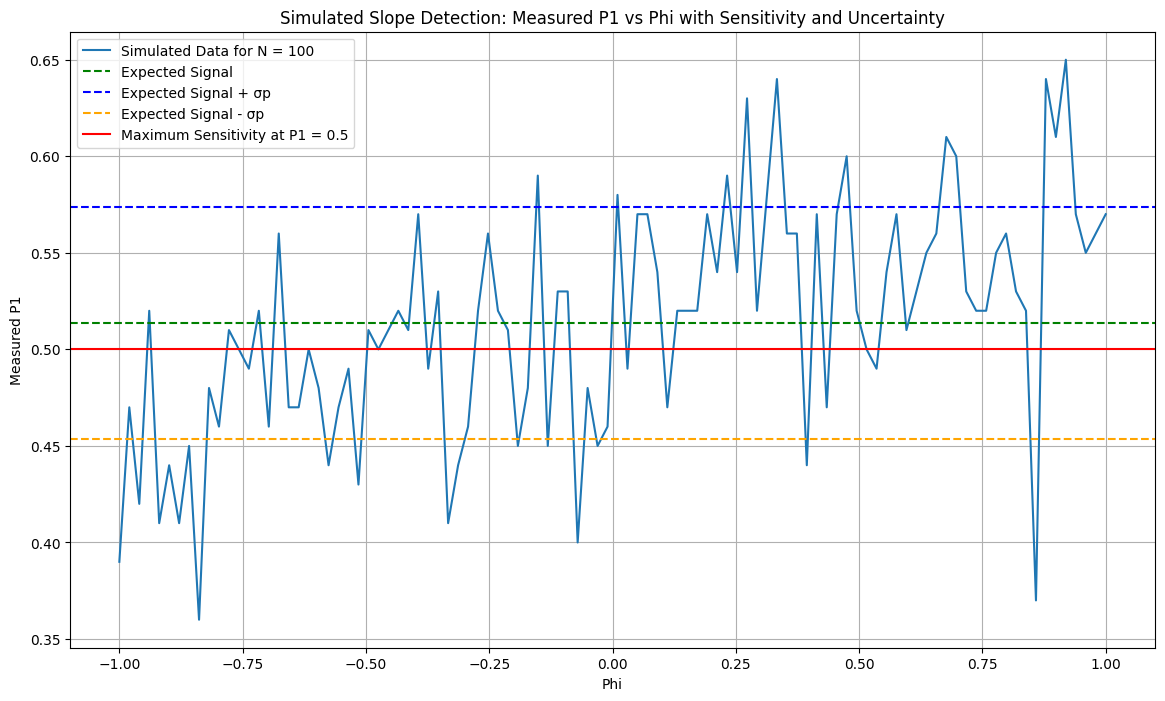

Expected Signal: 0.5137
Std dev: 0.05999424972445276


In [58]:
N = 100 

# calculate the expected signal (mean of P1) and the standard deviation (σp)
expected_signal = np.mean(simulated_slope_data[N]) # binomially distributed
sigma_p = np.std(simulated_slope_data[N])

# calculate the expected signal plus σp and the expected signal minus σp
expected_signal_plus_sigma = expected_signal + sigma_p
expected_signal_minus_sigma = expected_signal - sigma_p

plt.figure(figsize=(14, 8))
plt.plot(phi_range, simulated_slope_data[N], label=f'Simulated Data for N = {N}')
plt.axhline(y=expected_signal, color='g', linestyle='--', label='Expected Signal')
plt.axhline(y=expected_signal_plus_sigma, color='b', linestyle='--', label='Expected Signal + σp')
plt.axhline(y=expected_signal_minus_sigma, color='orange', linestyle='--', label='Expected Signal - σp')
plt.axhline(y=0.5, color='r', linestyle='-', label='Maximum Sensitivity at P1 = 0.5')
plt.title('Simulated Slope Detection: Measured P1 vs Phi with Sensitivity and Uncertainty')
plt.xlabel('Phi')
plt.ylabel('Measured P1')
plt.legend()
plt.grid(True)
plt.show()

print(f"Expected Signal: {expected_signal}")
print(f"Std dev: {sigma_p}")


As expected, we see the expected signal lies close to 0.5. For this distribution, about 68% of the data should fall within one standard deviation of the mean, which is what we see here. 